# SCHEMAS

In [1]:
from typing import List, Optional, Dict
from typing_extensions import TypedDict, NotRequired, Annotated
import operator


from pdf_hunter.agents.pdf_extraction.schemas import ExtractedImage, ExtractedURL
from pdf_hunter.agents.image_analysis.schemas import ImageAnalysisReport
from pdf_hunter.agents.pdf_extraction.schemas import PDFHashData
from pdf_hunter.agents.file_analysis.schemas import EvidenceGraph, FinalReport
from pdf_hunter.agents.url_investigation.schemas import URLAnalysisResult
from pdf_hunter.agents.report_generator.schemas import FinalVerdict

In [2]:
class OrchestratorState(TypedDict):
    """
    The master state for the PDF-Hunter orchestrator.
    It holds the initial inputs and collects the final reports from all sub-agents.
    """
    # --- Initial User Inputs ---
    file_path: str
    output_directory: str
    number_of_pages_to_process: int
    pages_to_process: Optional[List[int]]
    additional_context: NotRequired[Optional[str]]
    session_id: NotRequired[Optional[str]]

    pdf_hash: Optional[PDFHashData]
    page_count: Optional[int]

    # --- Results from Preprocessing Agent ---
    extracted_images: List[ExtractedImage]
    extracted_urls: List[ExtractedURL]

    # --- Results from Visual Analysis Agent ---
    visual_analysis_report: NotRequired[ImageAnalysisReport]

    # --- Results from Static Analysis Agent ---
    structural_summary: Dict[str, str]
    master_evidence_graph: NotRequired[EvidenceGraph]
    triage_classification_decision: NotRequired[str]
    triage_classification_reasoning: NotRequired[str]
    static_analysis_final_report: NotRequired[FinalReport]

    # --- Results from Link Analysis Agent ---
    link_analysis_final_reports: Annotated[List[URLAnalysisResult], operator.add]

    # --- Results from Finalization Agent ---
    final_report: NotRequired[str]
    final_verdict: NotRequired[FinalVerdict]

    # --- Global Error Tracking ---
    errors: Annotated[List[list], operator.add]


class OrchestratorInputState(TypedDict):
    file_path: str
    output_directory: NotRequired[Optional[str]]
    number_of_pages_to_process: int
    additional_context: NotRequired[Optional[str]]
    session_id: NotRequired[Optional[str]]


# class OrchestratorOutputState(TypedDict):
#     final_verdict: NotRequired[FinalVerdict]

# GRAPH

In [3]:
from langgraph.graph import StateGraph, START, END

from pdf_hunter.agents.pdf_extraction.graph import preprocessing_graph
from pdf_hunter.agents.image_analysis.graph import visual_analysis_graph
from pdf_hunter.agents.file_analysis.graph import static_analysis_graph
from pdf_hunter.agents.url_investigation.graph import link_analysis_graph
from pdf_hunter.agents.report_generator.graph import report_generator_graph
from pdf_hunter.config.logging_config import setup_logging
from pdf_hunter.config import ORCHESTRATOR_CONFIG

In [4]:
orchestrator_builder = StateGraph(OrchestratorState, input_schema=OrchestratorInputState)#, output_schema=OrchestratorOutputState)

orchestrator_builder.add_node("PDF Extraction", preprocessing_graph)
orchestrator_builder.add_node("File Analysis", static_analysis_graph)
orchestrator_builder.add_node("Image Analysis", visual_analysis_graph)
orchestrator_builder.add_node("URL Investigation", link_analysis_graph)
orchestrator_builder.add_node("Report Generator", report_generator_graph)
orchestrator_builder.add_edge(START, "PDF Extraction")
orchestrator_builder.add_edge("PDF Extraction", "File Analysis")
orchestrator_builder.add_edge("PDF Extraction", "Image Analysis")
orchestrator_builder.add_edge("Image Analysis", "URL Investigation")
orchestrator_builder.add_edge(["File Analysis", "URL Investigation"], "Report Generator")
orchestrator_builder.add_edge("Report Generator", END)

orchestrator_graph = orchestrator_builder.compile()
orchestrator_graph = orchestrator_graph.with_config(ORCHESTRATOR_CONFIG)

In [5]:
from IPython.display import Image, display

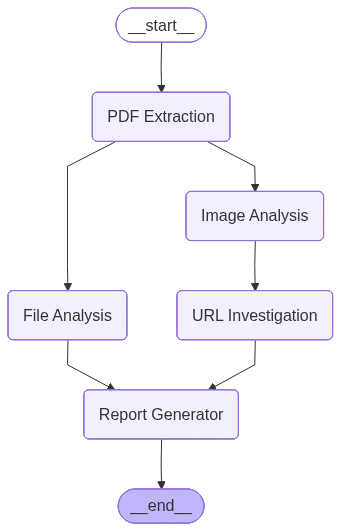

In [6]:
display(Image(orchestrator_graph.get_graph().draw_mermaid_png()))

In [7]:
file_path = "/Users/gorelik/Courses/pdf-hunter/tests/assets/pdfs/87c740d2b7c22f9ccabbdef412443d166733d4d925da0e8d6e5b310ccfc89e13.pdf"
number_of_pages_to_process = 3

In [8]:
orchestrator_input = {
    "file_path": file_path,
    "output_directory": "output",
    "number_of_pages_to_process": number_of_pages_to_process,
    "additional_context": "None"
}

In [ ]:
final_state = await orchestrator_graph.ainvoke(orchestrator_input)

In [10]:
final_state.keys()

dict_keys(['file_path', 'output_directory', 'number_of_pages_to_process', 'pages_to_process', 'additional_context', 'session_id', 'pdf_hash', 'page_count', 'extracted_images', 'extracted_urls', 'visual_analysis_report', 'structural_summary', 'triage_classification_decision', 'triage_classification_reasoning', 'static_analysis_final_report', 'link_analysis_final_reports', 'final_verdict', 'errors'])